<!-- dom:TITLE: Polynomial interpolation  -->
# Exercises 6: Numerical Solution of ODE's 1
<!-- dom:AUTHOR: Alvar Wallström Lindell
<!-- Author: -->  

TMA4130 - Mathematics 4N  /
TMA4135 - Mathematics 4D 

* Date: **Oct 6, 2021**
* Submission deadline: **Oct 20, 2021**

If you want to have a nicer theme for your jupyter notebook,
download the [cascade stylesheet file calculus4N.css](https://www.math.ntnu.no/emner/TMA4130/2021h/lectures/calculus4N.css)
and execute the next cell:

In [71]:
from IPython.core.display import HTML
def css_styling():
    try:
        with open("calculus4N.css", "r") as f:
            styles = f.read()
            return HTML(styles)
    except FileNotFoundError:
        print("Not found")
        pass #Do nothing

# Comment out next line and execute this cell to restore the default notebook style 
css_styling()

In [72]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
import numpy as np

plt.xkcd()
newparams = {'figure.figsize': (6.0, 6.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

In this exercise set you will be analyzing and implementing the following explicit Runge-Kutta methods:

Midpoint rule
$$
\begin{array}{c|cc}
0 & 0 & 0 \\ 
\tfrac{1}{2} & \frac{1}{2} & 0 \\ \hline
& 0 & 1
\end{array}
$$
Gottlieb \& Gottlieb's 3-stage Runge-Kutta (SSPRK3)
$$
\begin{array}{c|cccc}
0 & 0 & 0 & 0 \\ 
1 & 1 & 0 & 0 \\ 
\tfrac{1}{2} & \tfrac{1}{4} & \tfrac{1}{4} & 0 \\
\hline
& \tfrac{1}{6} & \tfrac{1}{6} & \tfrac{2}{3} 
\end{array}
$$

### **Exercise 1** 
#### Convergence orders
Calculate analytically the convergence order's of the two methods. Use the order's conditions given in the lectures.

In [73]:
# creates a function that will return the convergene order given a vector b, n x n matrice and a vector c
def calculate_convergence(a, b, c):
    n = len(b)
    if (sum(b) == 1):
        sum_order2 = 0
        for i in range(n):
            sum_order2 += b[i] * c[i]
            
        if (sum_order2 == 1/2):
            sum_order3_1 = 0
            sum_order3_2 = 0
            for i in range(n):
                sum_order3_1 += b[i] * c[i]**2
                for j in range(n):
                    sum_order3_2 += b[i] * a[i][j] * c[j]
            
            if (sum_order3_1 == 1/3 and sum_order3_2 == 1/6):
                sum_order4_1 = 0
                sum_order4_2 = 0
                sum_order4_3 = 0
                sum_order4_4 = 0
                
                for i in range(n):
                    sum_order4_1 += b[i] * c[i]**3
                    for j in range(n):
                        sum_order4_2 += b[i] * c[i] * a[i][j] * c[j]
                        sum_order4_3 += b[i] * a[i][j] * c[j]**2
                        for k in range(n):
                            sum_order4_4 += b[i] * a[i][j] * a[j][k] * c[k]
                if (sum_order4_1 == 1/4 and sum_order4_2 == 1/8 and sum_order4_3 == 1/12 and sum_order4_4 == 1/24):
                    return 4
                else:
                    return 3       
            else:
                return 2
        else:
            return 1
    else:
        return 0

In [74]:
# midpoint rule
a_m = np.array([[0, 0], [1/2, 0]])
b_m = np.array([0, 1])
c_m = np.array([0, 1/2])

print("Order of convergence for midpoint rule:", calculate_convergence(a_m, b_m, c_m))

# SSPRK3
a_ssp = np.array([[0, 0, 0], [1, 0, 0], [1/4, 1/4, 0]])
b_ssp = np.array([1/6, 1/6, 2/3])
c_ssp = np.array([0, 1, 1/2])

print("Order of convergence for SSPRK3:", calculate_convergence(a_ssp, b_ssp, c_ssp))

Order of convergence for midpoint rule: 2
Order of convergence for SSPRK3: 3


### **Exercise 2** 
#### Implementing and testing the methods
In this exercise we will numerically solve the ODE
$$
y'(t) = f(y), \quad y(0) = y_0
$$
in the interval $t \in [0,T]$.

**a)** Implement two `Python` functions ```explicit_mid_point_rule``` and ```ssprk3```
which implement the Runge-Kutta methods from Exercise 1.
Each solver function should take as arguments:
  * The initial value $y_0$
  * The inital time $t_0$
  * The final time $T$
  * The right-hand side $f$
  * The maximum number of time-steps $N_{max}$

    
The function should return two arrays:
  * One array `ts` containing all the time-points  
      $0 = t_0,t_1,...,t_N = T$ 
  * One array `ys` containing all the function values  
      $y_0,y_1,...,y_N$

Test the methods on the ODE
$$
y'(t) = -y(t), \quad y(0) = 1, \quad t \in [0,10].
$$

_**Hint:**_ Use the code for `explicit_euler` in the lecture notes or use the [supporting material](https://wiki.math.ntnu.no/tma4130/2021h/learning_material) e.g. `Heun` in IntroductionNuMeODE, and modify it to each required method.

In [75]:
def explicit_midpoint_rule(y0, t0, T, f, N_max):
    ts = [t0]
    ys = [y0]
    tau = (T - t0)/N_max
    
    # butcher table
    a = np.array([[0, 0], [1/2, 0]])
    b = np.array([0, 1])
    c = np.array([0, 1/2])
    
    s = len(b)
    ks = [np.zeros_like(y0, dtype=np.double) for s in range(s)]
    
    while (ts[-1] < T):
        t, y = ts[-1], ys[-1]
        # computing k_j's 
        for j in range(s):
            dY = 0
            for l in range(j):
                dY += a[j][l] * ks[l]
            ks[j] = f(t + c[j] * tau, y + tau * dY)
        dY = 0
        for j in range(s):
            dY += b[j]*ks[j]
        ts.append(t + tau)
        ys.append(y + tau*dY)
    
    return ts, ys

def explicit_ssprk3(y0, t0, T, f, N_max):
    # initial values
    ts = [t0]
    ys = [y0]
    tau = (T - t0)/N_max
    
    # butcher table
    a = np.array([[0, 0, 0], [1, 0, 0], [1/4, 1/4, 0]])
    b = np.array([1/6, 1/6, 2/3])
    c = np.array([0, 1, 1/2])
    
    s = len(b)
    ks = [np.zeros_like(y0, dtype=np.double) for s in range(s)]
    
    while (ts[-1] < T):
        t, y = ts[-1], ys[-1]
        # computing k_j's 
        for j in range(s):
            dY = np.zeros_like(y, dtype=np.double)
            for l in range(j):
                dY += a[j][l] * ks[l]
            ks[j] = f(t + c[j] * tau, y + tau * dY)
        dY = np.zeros_like(y, dtype=np.double)
        for j in range(s):
            dY += b[j]*ks[j]
        ts.append(t + tau)
        ys.append(y + tau*dY)
    return np.array(ts), np.array(ys)

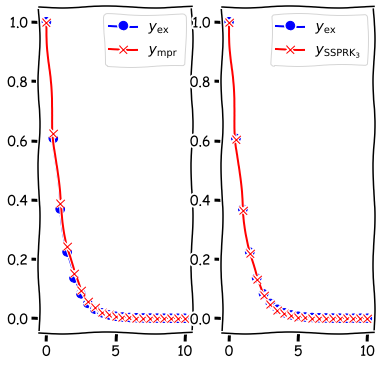

In [76]:
y0 = 1
t0 = 0
T = 10
N_max = 20


def f(t, y):
    return -y

# exact solution (exp(-t))
def y_ex(t):
    return np.exp(-t)

fig, axes = plt.subplots(1,2)
ts, ys_mdr = explicit_midpoint_rule(y0, t0, T, f, N_max)
ys_ex = []
for t in ts:
    ys_ex.append(y_ex(t))
axes[0].plot(ts, ys_ex, 'bo-')
axes[0].plot(ts, ys_mdr, 'rx-')
axes[0].legend(["$y_{\mathrm{ex}}$", "$y_{\mathrm{mpr}}$" ])
ts, ys_ssprk3 = explicit_ssprk3(y0, t0, T, f, N_max)
axes[1].plot(ts, ys_ex, 'bo-')
axes[1].plot(ts, ys_ssprk3, 'rx-')
axes[1].legend(["$y_{\mathrm{ex}}$", "$y_{\mathrm{SSPRK_3}}$" ])

**b)**
We will now numerically investigate the RK-methods. We can do this since we know what the exact solution to the ODE above is. We assume that the error $e = |y(T) - y_N|$ when using step size $\tau$ is approximately
$$
e \approx C\tau^p
$$
for some $C>0$ and $p.$ Note that $p$ is what we call the convergence order. We assume that $p$ and $C$ is the same when using different step sizes $h$. Let $e_1$ and $e_2$ be the errors when using step sizes $h_1$ and $h_2$. Then we have

$$
\frac{e_1}{e_2} \approx \frac{\tau_1^p}{\tau_2^p} = \left(\frac{\tau_1}{\tau_2}\right)^p.
$$
Taking logarithms on both sides we get
$$
\log(e_1/e_2) \approx p \log(\tau_1/\tau_2)
$$
or
$
\begin{align}
p \approx& \frac{\log(e_1/e_2)}{\log(\tau_1/\tau_2)}.
\end{align}
$
The value on the right-hand side of this equation is what we call the Experimental Order of Convergence, or EOC. We will now try to estimate the order of convergence using EOC-values.

Do the following for each method:
1. For m=0,...,5, set $\tau_m=2^{-m}$ and find the value of $N_{max}$ for each $m$. 
2. Find the numerical solution $y_{N(m)}$ of the ODE at $T = 10$.
2. Calculate the error $e_m = |y(10) - y_{N_{max,m}}|$.
3. Calculate the EOC for neighbouring step sizes, that is using equation (1) above with $e_m$ and $e_{m+1}$ for $m=0,...,4$. This should give you $5$ different approximations. 

Draw a conclusion about the order of convergence $p$ for each method. Does it agree with the result in exercise 1?

In [77]:
# N_max will be the same for both methods.
m = [i for i in range(6)]
t0 = 0
T = 10
N_maxes = []
# N_max = (T - t0)*2^m
for i in m:
    N_maxes.append((T - t0) * 2**i)

# solving the ODE with different N_max
# dont need to store the result, only need to store the last value, eg y_N
ys_Nmax_mpr = []
ys_Nmax_ssprk = []

for N_m in N_maxes:
    ts, ys = explicit_midpoint_rule(y0, t0, T, f, N_m) # f is the same as defined above
    ys_Nmax_mpr.append(ys[-1])
    ts, ys = explicit_ssprk3(y0, t0, T, f, N_m)
    ys_Nmax_ssprk.append(ys[-1])

# calculating the errors
e_m_mpr_list = []
e_m_ssprk_list = []

for i in range(6):
    # midpoint rule
    e_m_mpr = np.absolute(y_ex(10) - ys_Nmax_mpr[i])
    e_m_mpr_list.append(e_m_mpr)
    # SSPRK3
    e_m_ssprk = np.absolute(y_ex(10) - ys_Nmax_ssprk[i])
    e_m_ssprk_list.append(e_m_ssprk)

# finally calculating the EOC
eoc_mpr_list = []
eoc_ssprk_list = []

for i in range(5):
    # midpoint rule
    p_mpr_i = (np.log(e_m_mpr_list[i]/e_m_mpr_list[i+1]))/(np.log(2**(-i)/2**(-i-1)))
    eoc_mpr_list.append(p_mpr_i)
    # SSPRK3
    p_ssprk_i = (np.log(e_m_ssprk_list[i]/e_m_ssprk_list[i+1]))/(np.log(2**(-i)/2**(-i-1)))
    eoc_ssprk_list.append(p_ssprk_i)

print("Midpoint rule:")
for i in range(5):
    print(f"tau_{i} = {2**(-i)},tau_{i+1} = {2**(-i-1)} gives "
          + f"experimental order of convergence p = {eoc_mpr_list[i]}")

print("\nSSPRK3:")
for i in range(5):
    print(f"tau_{i} = {2**(-i)},tau_{i+1} = {2**(-i-1)} gives "
          + f"experimental order of convergence p = {eoc_ssprk_list[i]}")


Midpoint rule:
tau_0 = 1,tau_1 = 0.5 gives experimental order of convergence p = 4.641084409856239
tau_1 = 0.5,tau_2 = 0.25 gives experimental order of convergence p = 2.618767003133043
tau_2 = 0.25,tau_3 = 0.125 gives experimental order of convergence p = 2.2053567418841813
tau_3 = 0.125,tau_4 = 0.0625 gives experimental order of convergence p = 2.0834717759359433
tau_4 = 0.0625,tau_5 = 0.03125 gives experimental order of convergence p = 2.0375876961837682

SSPRK3:
tau_0 = 1,tau_1 = 0.5 gives experimental order of convergence p = 3.0609310003784023
tau_1 = 0.5,tau_2 = 0.25 gives experimental order of convergence p = 3.244464219011232
tau_2 = 0.25,tau_3 = 0.125 gives experimental order of convergence p = 3.1402030351845105
tau_3 = 0.125,tau_4 = 0.0625 gives experimental order of convergence p = 3.0717942133260796
tau_4 = 0.0625,tau_5 = 0.03125 gives experimental order of convergence p = 3.036056209583162


**c)**
We will finally test both methods on the ODE

\begin{align*}
y'(t) =& -2ty(t), &\quad y(0) = 1, &\quad t \in [0,0.5].
\end{align*}

This has exact solution $e^{-t^2}$. Find the approximate value of $y(0.5)$ using 
   * The midpoint method with $N_{max} = 3$
   * The SSPRK3 method with $N_{max} = 2$  
   
The number of step sizes are chosen such that each method needs to perform 6 evaluations of the function $f$. How do the errors $e = |y(T) - y_{N_{max}}|$ compare?

_Additional exercise:_ Does this observation holds for other values of $T$? For instance, with $T=0.2$ or $T=0.8$. Can you tell what happens to $y$ or $y^\prime$ in $T=0.5$? 

Error for midpoint rule: e = 0.002543491722271085
Error for SSPRK3: e = 0.0010497081744864634


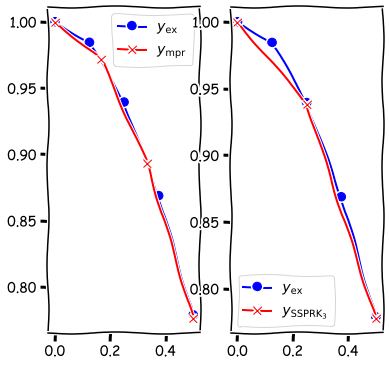

In [78]:
# defining the exact solution
def y_ex(t):
    return np.exp(-t**2)

# defining g (right hand side of the equation)
def g(t, y):
    return -2*t*y

# initial values
y0 = 1
t0 = 0
T = 0.5
N_max_mpr = 3
N_max_ssprk = 2

# solving the IVP
ts_mpr, ys_mpr = explicit_midpoint_rule(y0, t0, T, g, N_max_mpr)
ts_ssprk, ys_ssprk = explicit_ssprk3(y0, t0, T, g, N_max_ssprk)

x = np.linspace(0, 0.5, 5)
ys_ex = []
for val in x:
    ys_ex.append(y_ex(val))


fig, axes = plt.subplots(1,2)
axes[0].plot(x, ys_ex, 'bo-')
axes[0].plot(ts_mpr, ys_mpr, 'rx-')
axes[0].legend(["$y_{\mathrm{ex}}$", "$y_{\mathrm{mpr}}$" ])
ts, ys_ssprk3 = explicit_ssprk3(y0, t0, T, f, N_max)
axes[1].plot(x, ys_ex, 'bo-')
axes[1].plot(ts_ssprk, ys_ssprk, 'rx-')
axes[1].legend(["$y_{\mathrm{ex}}$", "$y_{\mathrm{SSPRK_3}}$" ])

e_mpr = np.absolute(y_ex(T) - ys_mpr[-1])
e_ssprk = np.absolute(y_ex(T) - ys_ssprk[-1])

print(f"Error for midpoint rule: e = {e_mpr}")
print(f"Error for SSPRK3: e = {e_ssprk}")

### **Exercise 3**
#### SIR Model

The SIR model is a system of first order ODE's which model the dynamics of a disease in a society.

There are $S(t)$ susceptible/healthy individuals, $I(t)$ infected individuals and $R(t)$ recovered individuals. Each susceptible person has a risk of becoming infected, a risk which is proportional to the number of infected people $I(t)$, with a proportinality constant $\beta>0.$ Each infected person also has a chance of recovering, with a recovery constant $\gamma>0$. This leads to the coupled system of first-order ODE's

$$
\begin{align*}
S'(t) = &  -\beta S(t) I(t),\\
I'(t) = &  \beta S(t) I(t) - \gamma I(t),\\
R'(t) = &  \gamma I(t).
\end{align*}
$$

We can rewrite this in vector form as

$$
\mathbf{u}'(t) = \mathbf{f}(\mathbf{u}(t))
$$

where we have defined

$$
\mathbf{u}(t) = 
\begin{pmatrix}
S(t)\\
I(t)\\
R(t)
\end{pmatrix}, \quad 
\mathbf{f}(\mathbf{u}(t)) = 
\begin{pmatrix}
-\beta S(t) I(t)\\
\beta S(t) I(t) - \gamma I(t)\\
\gamma I(t)
\end{pmatrix}.
$$

**a)** Show that the system is conservative, that is that the total number of individuals $S(t)+I(t)+R(t)$ is constant.

_Hint:_ remember which is the derivative of a constant function.

If we add the 3 equations we will get:
$$S'(t) + I'(t) + R'(t) = - \beta S(t)I(t) + \beta S(t)I(t) - \gamma I(t) + \gamma I(t)$$
$$S'(t) + I'(t) + R'(t) = 0 $$
If we now integrate on both sides we will get:
$$ S(t) + I(t) + R(t) = \int_0^{\infty} 0 dt$$
$$ S(t) + I(t) + R(t) = C $$,
where C is a constant, $S$ is the antiderivative of $S'(t)$, $I$ is the antiderivative of $I'(t)$ and $R$ is the antiderivative of $R'(t)$. This shows that the sum of these 3 functions will always be a constant. 

**b)** Numerically solve the system 
$$
\mathbf{u}'(t) = \mathbf{f}(\mathbf{u}(t)),\quad \mathbf{u}(0) = \mathbf{u}_0,\quad t\in [0,T]
$$
with either of the RK-methods above.

* You may pick end-time $T$ and $N_{max}$, 
* Choose an initial number of individuals.
    * A suitable inital conditions could e.g. be $\mathbf{u}_0 = (50,10,0)^T$. 
* Plot the solution as a function of time. 
* Also plot the total number of individuals. 
    * Is the total number conserved? To check this, you might calculate the maximum total and the minimum total over the interval.
* The parameters $\beta=0.2$ and $\gamma=0.15$ can be helpful for ilustration.

If you need a guide for this problem, you can look at the Lotka-Volterra model. It was presented in the lectures and is also available in the learning material on the wiki-page.

Text(0, 0.5, 'Number of people')

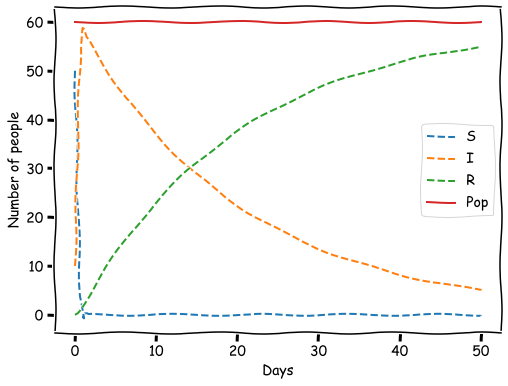

In [79]:
T = 50
t0 = 0
I0 = 1/200000
S0 = 1 - I0
R0 = 0
u0 = np.array([50, 10, 0])
N_max = 150
beta = 0.1
gamma = 0.05

def f(t, u):
    return np.array([-beta*u[0]*u[1],
                     beta*u[0]*u[1] - gamma*u[1],
                     gamma * u[1]
                    ])

def totalPopulation(u):
    return u[0] + u[1] + u[2]

ts, ys = explicit_ssprk3(u0, t0, T, f, N_max)
pop = np.zeros(len(ys))
ts_pop = np.zeros(len(ys))
for i in range(len(ys)):
    ts_pop[i] = ts[i]
    pop[i] = totalPopulation(ys[i])

newparams['figure.figsize'] = (8,6)
plt.rcParams.update(newparams)
plt.plot(ts, ys, "--")
plt.plot(ts_pop, pop, "-")
plt.legend(["S", "I", "R", "Pop"])
plt.xlabel("Days")
plt.ylabel("Number of people")

_Additional exercise:_ modify the SIR model such that the population is not longer constant. One idea is to have a proportion of the infected population to die with rate $\delta$. Test the new model as before.